Fig. 1: Combining RNA velocity with cell-cell similarity to determine initial and terminal states and compute a global map of cellular fate potential.
----
Uses [dyngen](https://github.com/dynverse/dyngen) simulated data to illustrate some of CellRank's main features. 

# Preliminaries

## Import packages

In [1]:
# import standard packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns

import os
import sys

# import single-cell packages
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [2]:
cr.logging.print_versions()

cellrank==1.5.0+g65f1562 scanpy==1.8.1 anndata==0.7.6 numpy==1.20.3 numba==0.54.0 scipy==1.7.1 pandas==1.3.3 pygpcca==1.0.2 scikit-learn==0.24.2 statsmodels==0.13.0rc0 python-igraph==0.9.1 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.4.3 seaborn==0.11.2


## Set up paths

Define the paths to load data, cache results and write figure panels.

In [3]:
sys.path.insert(0, "../..")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, CACHE_DIR, FIG_DIR

In [4]:
# we're only saving into one directory, so let's make life a little simpler
FIG_DIR = FIG_DIR / "fig_1_concept"

Set up the paths to save figures.

In [5]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Set up caching

Note: we use a caching extension called `scachepy` for this analysis, see [here](https://github.com/theislab/scachepy). We do this to speed up the runtime of this notebook by avoiding the most expensive computations. Below, we check whether you have scachepy installed and if you don't, then we automatically recompute all results. 

In [6]:
try:
    import scachepy
    c = scachepy.Cache(CACHE_DIR / "dyngen_simulated_data", separate_dirs=True)
    print('Sucessfully imported scachepy. Expensive computations will be cached. ')
except ImportError:
    c = None
    print('Failed to import scachepy. Consider installing it from `https://github.com/theislab/scachepy`. ')
use_caching = c is not None
c

Sucessfully imported scachepy. Expensive computations will be cached. 


Cache(root=/Users/marius/Projects/cellrank_reproducibility_2/cache/dyngen_simulated_data, ext='.pickle', compression='None')

## Set global parameters

Set some plotting parameters.

In [7]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

Set other global parameters:

In [8]:
# should figures just be displayed or also saved?
save_figure = True

# should cashed values be used, or recompute?
force_recompute = False

## Load the data

Load simulated data we created using [dyngen](https://github.com/dynverse/dyngen). This dataset is small (1MB) and can be found in [../../data/dyngen_simulated_data/bifurcating.h5ad](../../data/dyngen_simulated_data/bifurcating.h5ad)

In [9]:
adata = scv.read(DATA_DIR / "dyngen_simulated_data" / "bifurcating.h5ad")
adata

AnnData object with n_obs × n_vars = 1000 × 250
    obs: 'cell_id', 'from', 'to', 'time', 'lineage', 'global_time', 'lin_time_sC -> sEndC', 'lin_time_sA -> sB', 'lin_time_sB -> sBmid', 'lin_time_sBmid -> sC', 'lin_time_sD -> sEndD', 'lin_time_sBmid -> sD'
    uns: 'endpoints', 'gt_velocities', 'lineage_colors', 'startpoints'
    obsm: 'X_emb', 'X_umap'
    layers: 'spliced', 'unspliced'

# Run basic analysis

## Pre-process the data, compute KNN graph

Often, we want to process the raw data a bit differently than the data in `.X`.

### Raw data

In [10]:
# create raw object
adata_raw = adata.copy()
sc.pp.filter_genes(adata_raw, min_cells=3)
scv.pp.normalize_per_cell(adata_raw)
sc.pp.log1p(adata_raw)

# annotate highly variable genes
sc.pp.highly_variable_genes(adata_raw)
adata.raw = adata_raw

filtered out 5 genes that are detected in less than 3 cells
Normalized count data: X, spliced, unspliced.
extracting highly variable genes
    finished (0:00:00)


### Data used for velocity calculation

In [11]:
# preprocessing for the actual adata object
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=34)
scv.pp.log1p(adata)

Filtered out 42 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 34 highly variable genes.


computing PCA
    on highly variable genes
    with n_comps=33
    finished (0:00:00)


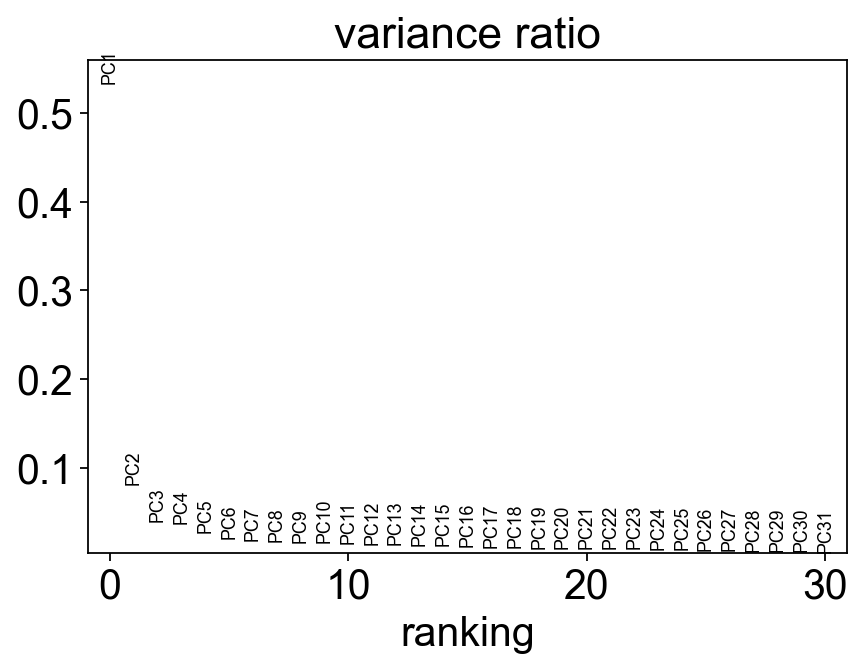

computing neighbors
    using data matrix X directly
    finished (0:00:02)


In [12]:
sc.tl.pca(adata, random_state=0)
sc.pl.pca_variance_ratio(adata)
sc.pp.neighbors(adata, n_pcs=7, n_neighbors=15, random_state=0)

## Visualise lineages in UMAP

This datset comes with a pre-computed UMAP and dyngen's lineage and time assignment. 

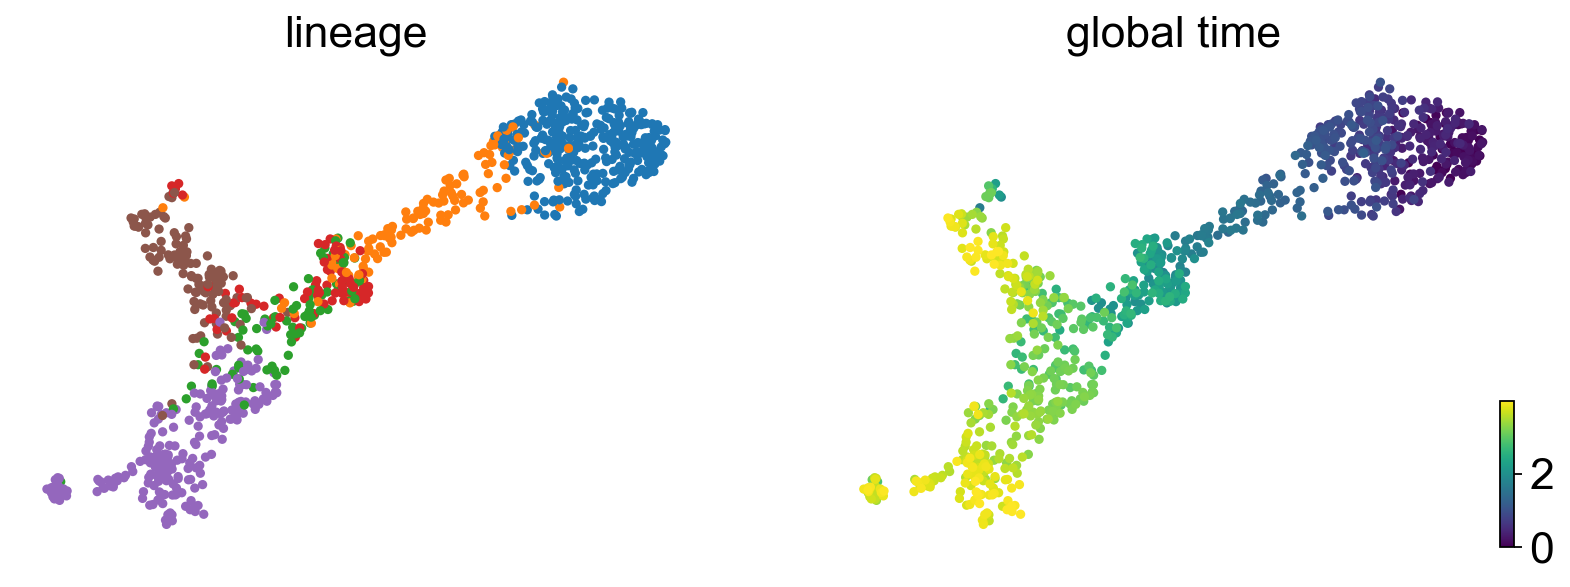

In [13]:
scv.pl.scatter(adata, color=['lineage','global_time'])

saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/fig_1_concept/purple_to_brown.pdf


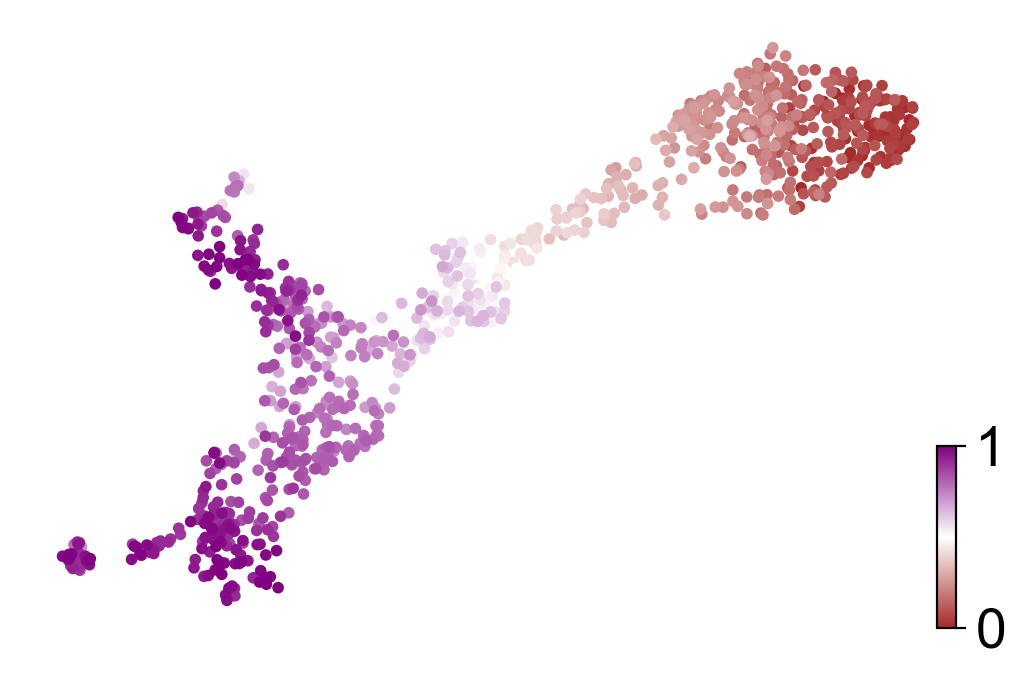

saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/fig_1_concept/viridis.pdf


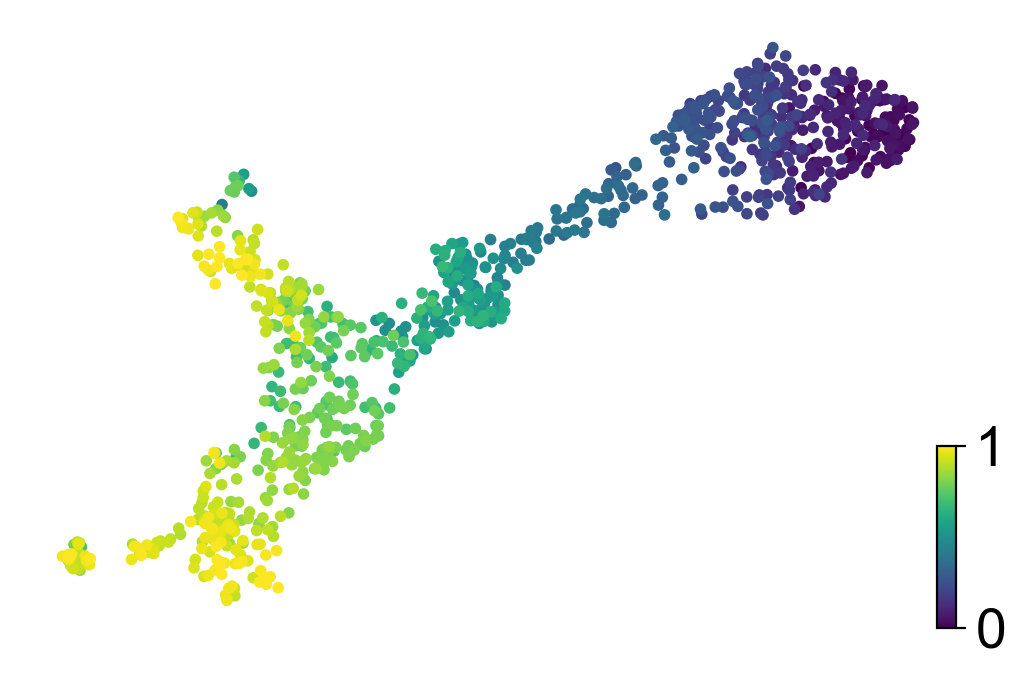

In [14]:
adata.obs['colorbar'] = adata.obs['global_time'] / np.max(adata.obs['global_time'])

fig_kwargs = {'color': 'colorbar', 'dpi': 100, 'color_map': ['brown', 'white', 'purple'], 'title': ''}
if save_figure: fig_kwargs['save'] = "purple_to_brown.pdf"  
scv.pl.scatter(adata, **fig_kwargs)

fig_kwargs = {'color': 'colorbar', 'dpi': 100, 'color_map': 'viridis', 'title': ''}
if save_figure: fig_kwargs['save'] = "viridis.pdf"
scv.pl.scatter(adata, **fig_kwargs)

## Compute velocities using scVelo

In [15]:
scv.pp.moments(adata, n_pcs=7)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [16]:
# adapt the same knn graph for the raw object and compute moments
adata_raw.obsp['connectivities'] = adata.obsp['connectivities'].copy()
adata_raw.obsp['distances'] = adata.obsp['distances'].copy()
adata_raw.uns['neighbors'] = adata.uns['neighbors'].copy()

scv.pp.moments(adata_raw, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [17]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')

recovering dynamics (using 1/8 cores)


  0%|          | 0/31 [00:00<?, ?gene/s]

    finished (0:00:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


## Project velocities onto the embedding

Often, we want to show velocities in the UMAP embedding here.

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


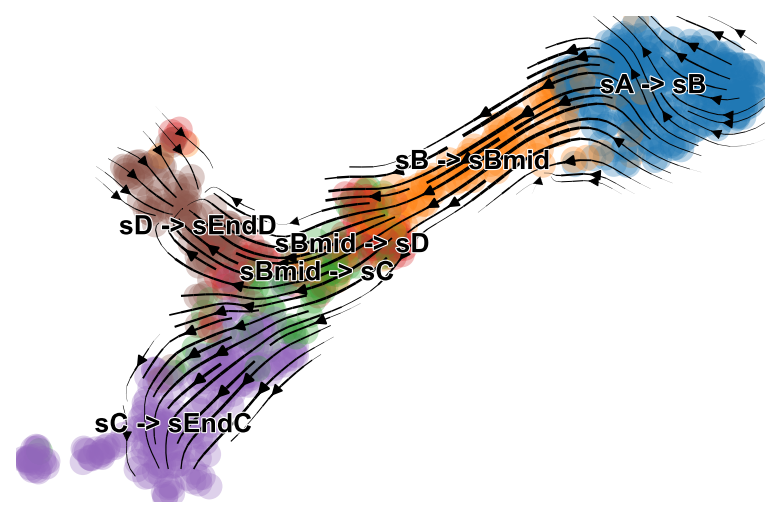

In [18]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, legend_fontsize=12, title='', smooth=0.8, min_mass=2.5, 
                                color='lineage')

## Show velocities in 3D

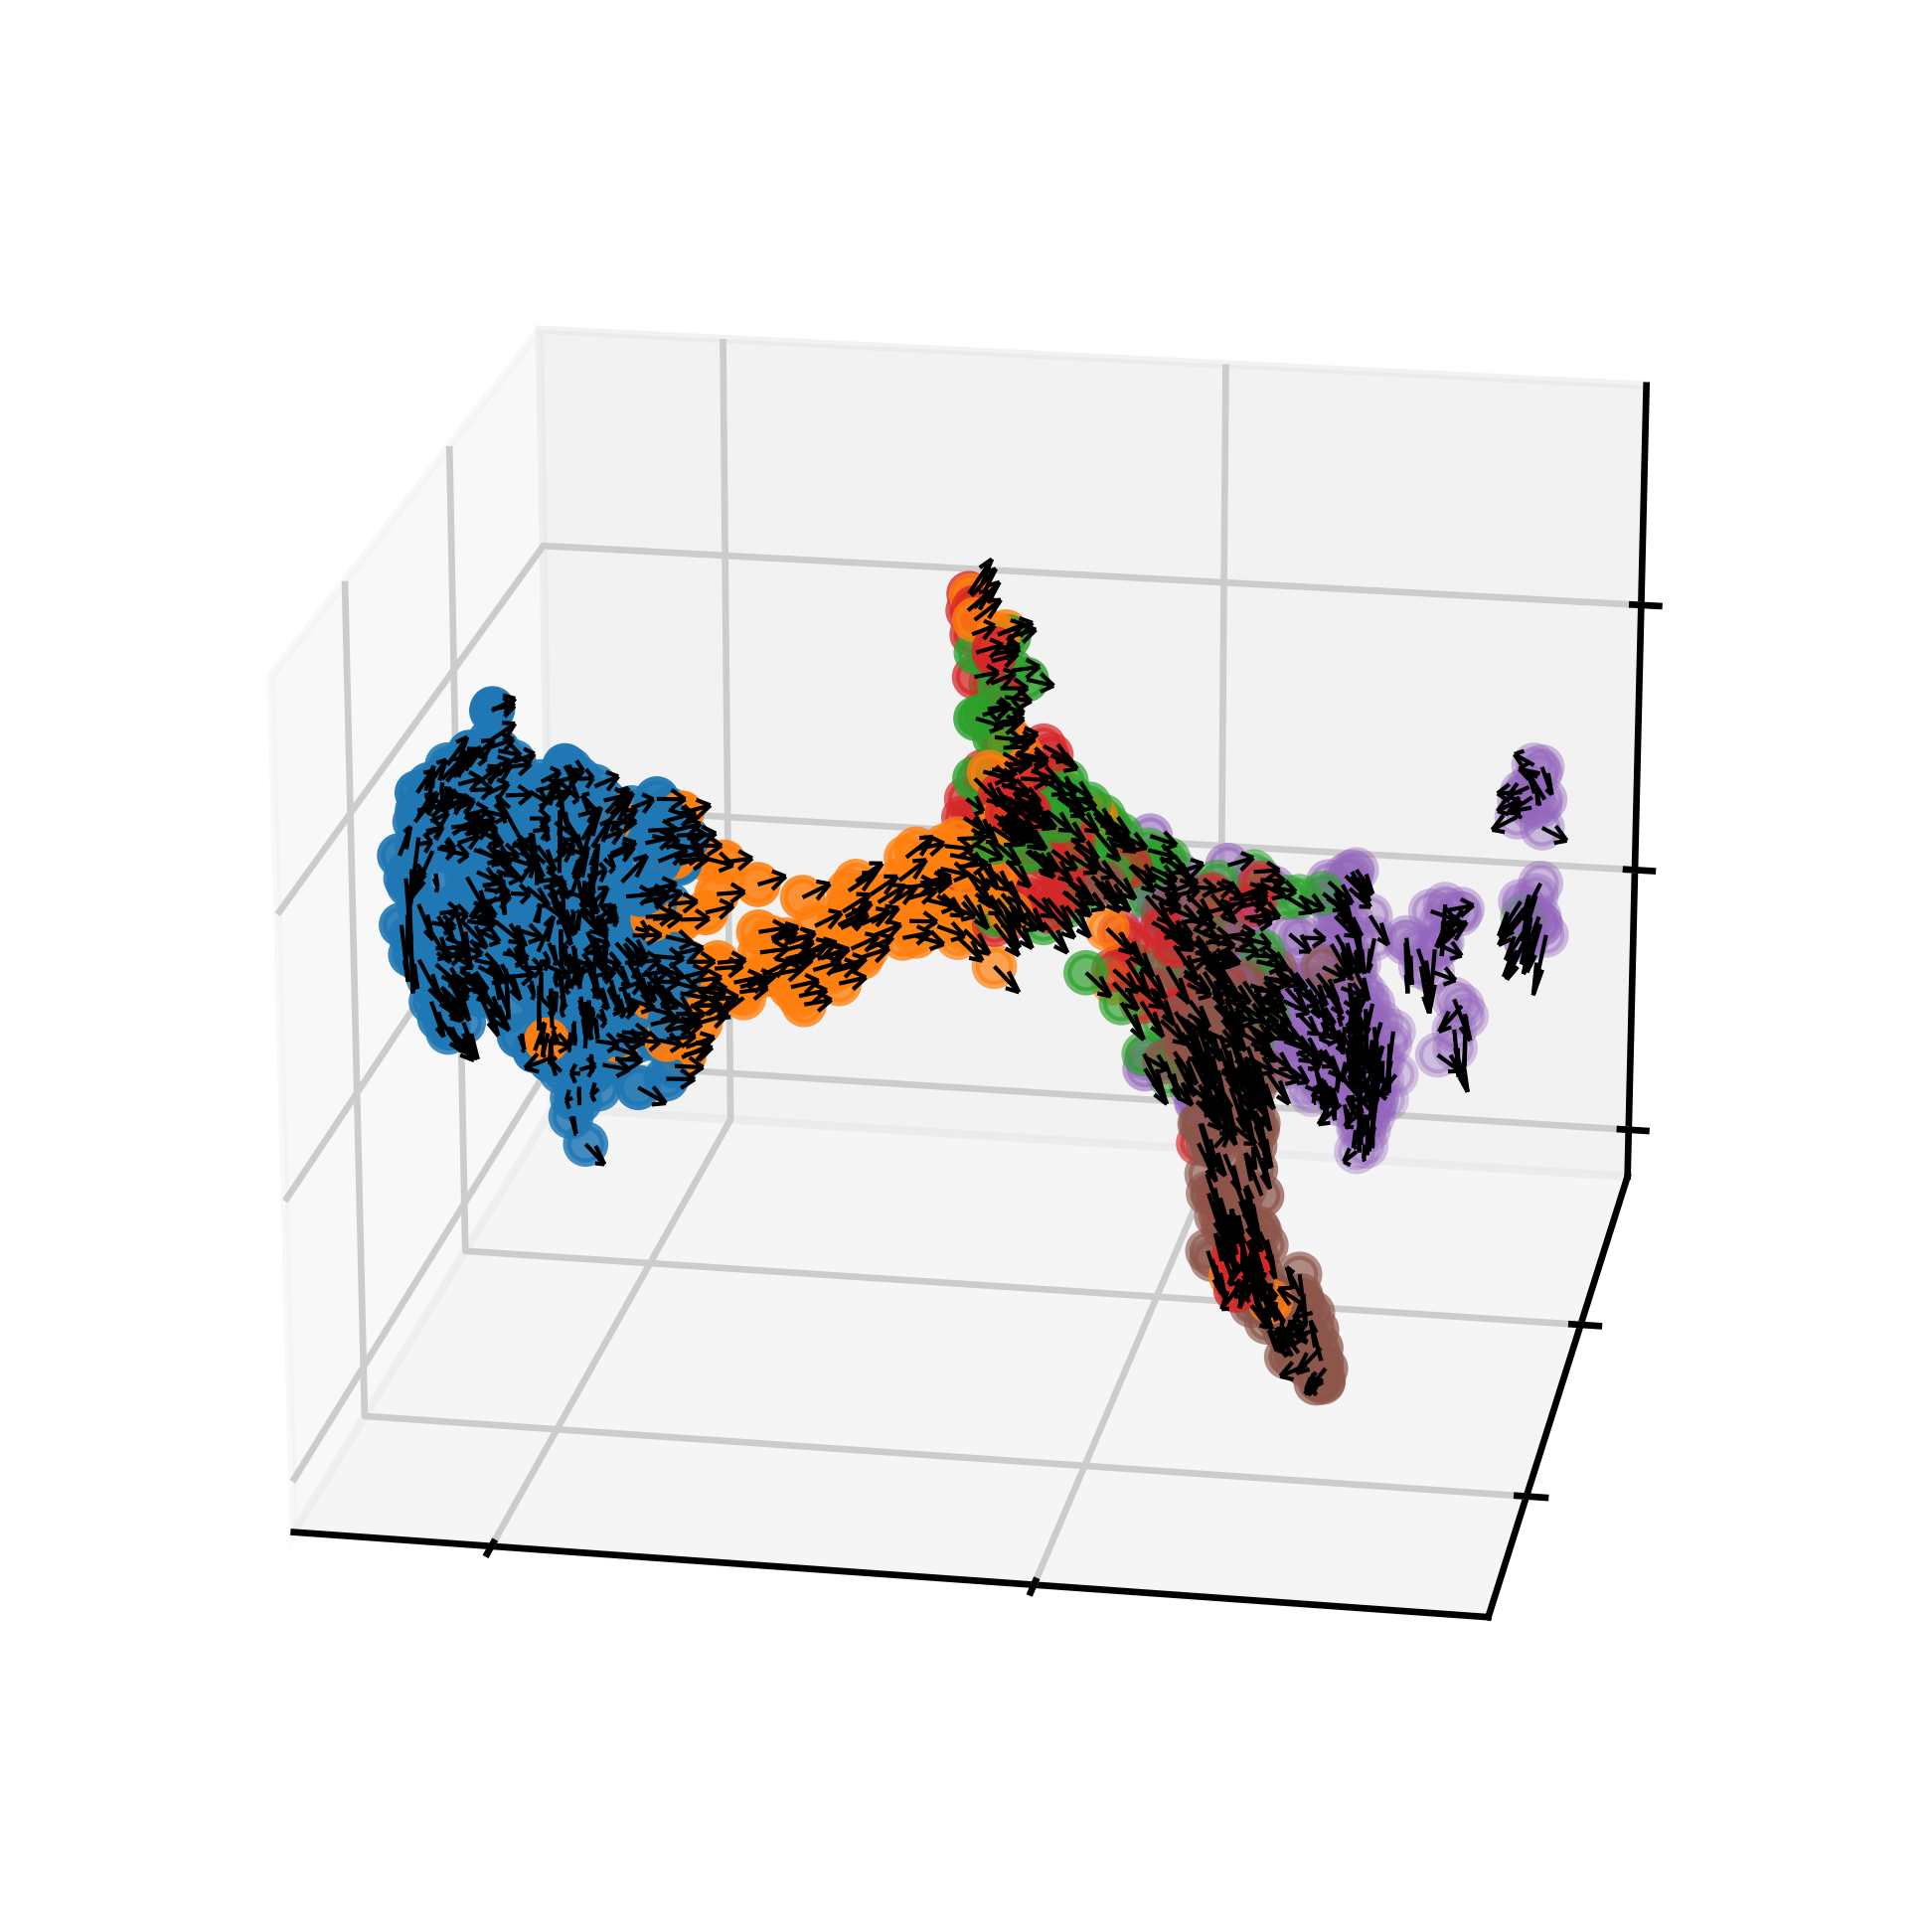

In [19]:
umap = adata.obsm['X_umap']
velocity = adata.obsm['velocity_umap']
color = scv.utils.interpret_colorkey(adata, c="lineage")

fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap[:, 0], umap[:, 1], umap[:, 2], c=color, cmap='viridis')

# Plot the velocity projection
ax.quiver(umap[:, 0], umap[:, 1], umap[:, 2], velocity[:, 0], velocity[:, 1], velocity[:, 2], color='k',
          normalize=True, length=0.5, arrow_length_ratio=0.5, linewidth = 0.5)

ax.view_init(20, 100)

# turn off the axis ticks
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.savefig(FIG_DIR / "high_dim_projection.pdf")
plt.show()

# Run CellRank

Typically, the second part of the analysis will involve CellRank. 

## Initialise kernel and estimator

This serves as an example of how to cach a transition matrix and of the default values we should be using. 

In [20]:
from cellrank.tl.estimators import GPCCA

# set the parameters we want to use to compute the transition matrix
weight_connectivities=0.2
mode="stochastic" 
n_jobs=8
softmax_scale=None

if use_caching:
    c.tl.transition_matrix(adata, 
                           weight_connectivities=weight_connectivities, 
                           mode=mode, 
                           n_jobs=n_jobs, 
                           softmax_scale=softmax_scale, 
                           fname='2021-09-21_transition_matrix_stochastic', 
                           force=force_recompute)
    g_fwd = GPCCA(adata, obsp_key='T_fwd')
else:
    kernel = cr.tl.transition_matrix(adata, 
                                     weight_connectivities=weight_connectivities, 
                                     mode=mode, 
                                     n_jobs=n_jobs, 
                                     softmax_scale=softmax_scale)
    g_fwd = GPCCA(kernel)
    
print(g_fwd)

Loading data from: `2021-09-21_transition_matrix_stochastic.pickle`.
GPCCA[n=1000, kernel=<PrecomputedKernel[origin=adata.obsp['T_fwd']]>]


## Print transition matrix statistics for reproducibility

To make sure that we're using the same transition matrix, show some stats. 

In [21]:
# just for consistency, display some summary staes about the transition matrix
T = adata.obsp['T_fwd']
T_med, T_mean, T_var = np.median(T.data), np.mean(T.data), np.var(T.data)
T_min, T_max = np.min(T.data), np.max(T.data)

print(f'med = {T_med:.6f},\nmean = {T_mean:.6f},\nvar = {T_var:.6f},\nmin = {T_min:.6f},\nmax = {T_max:.6f}')

med = 0.016503,
mean = 0.023255,
var = 0.000491,
min = 0.000572,
max = 0.505404


## Compute the real Schur decomposition

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[6, 9]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:01)


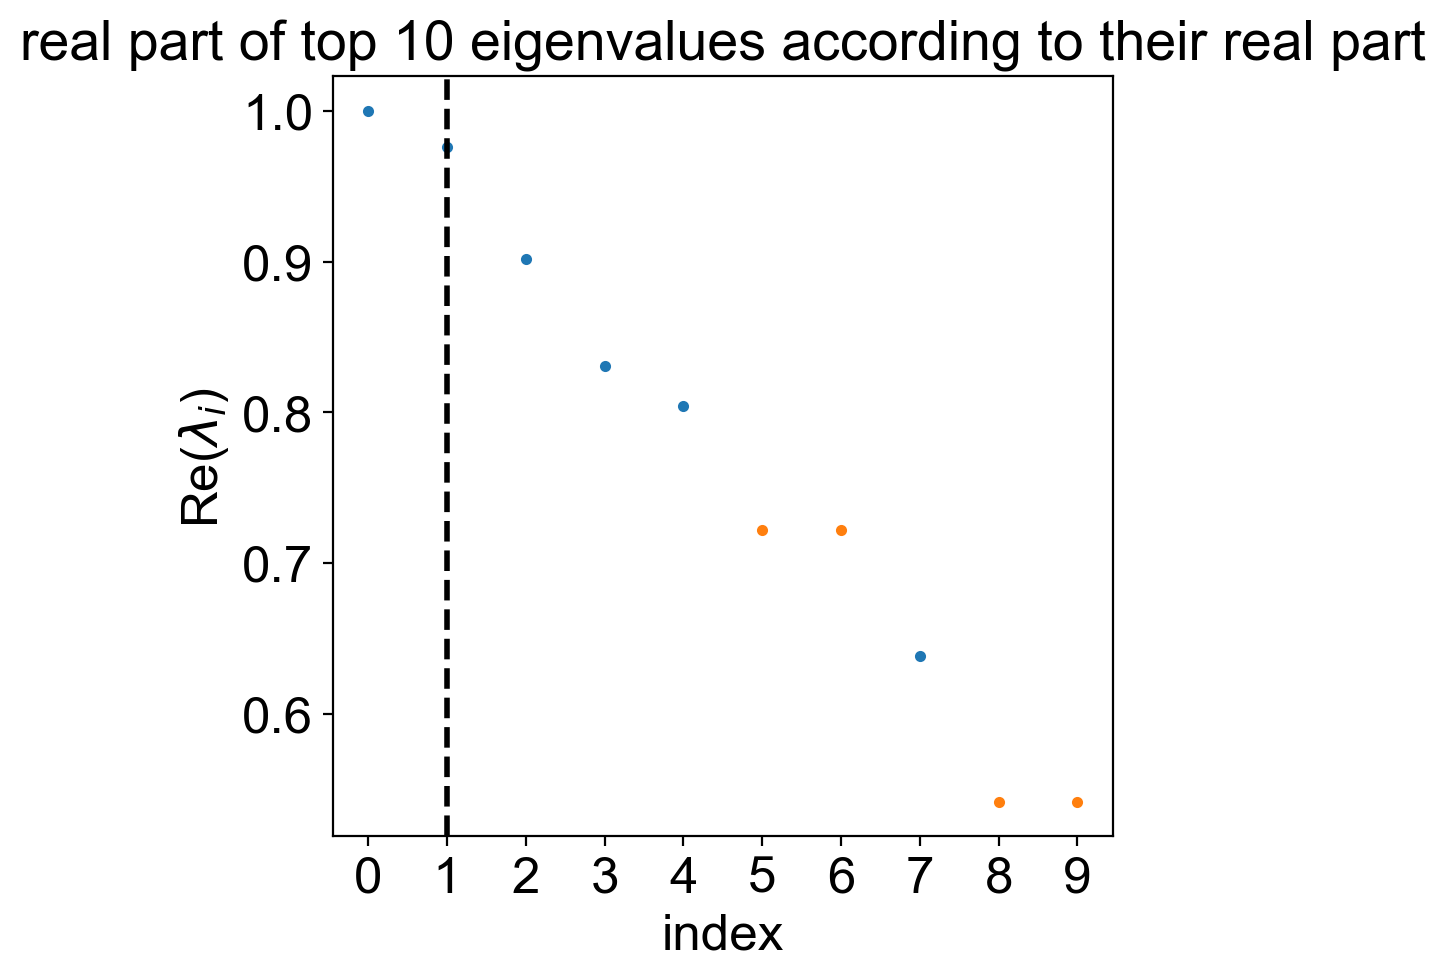

In [22]:
g_fwd.compute_schur()
g_fwd.plot_spectrum(real_only=True)

## Decompose into macrostates

Computing `4` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/fig_1_concept/macrostates.pdf


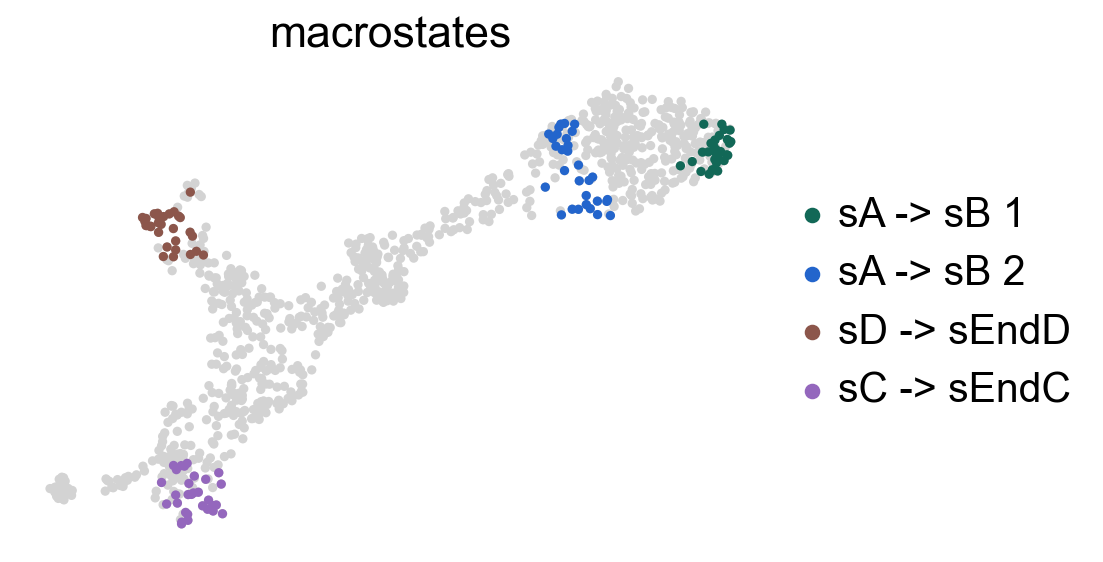

In [23]:
g_fwd.compute_macrostates(n_states=4, cluster_key='lineage')

fig_kwargs = {'discrete': True, 'legend_loc': 'right'}
if save_figure: fig_kwargs['save'] = "macrostates.pdf"
g_fwd.plot_macrostates(**fig_kwargs)

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


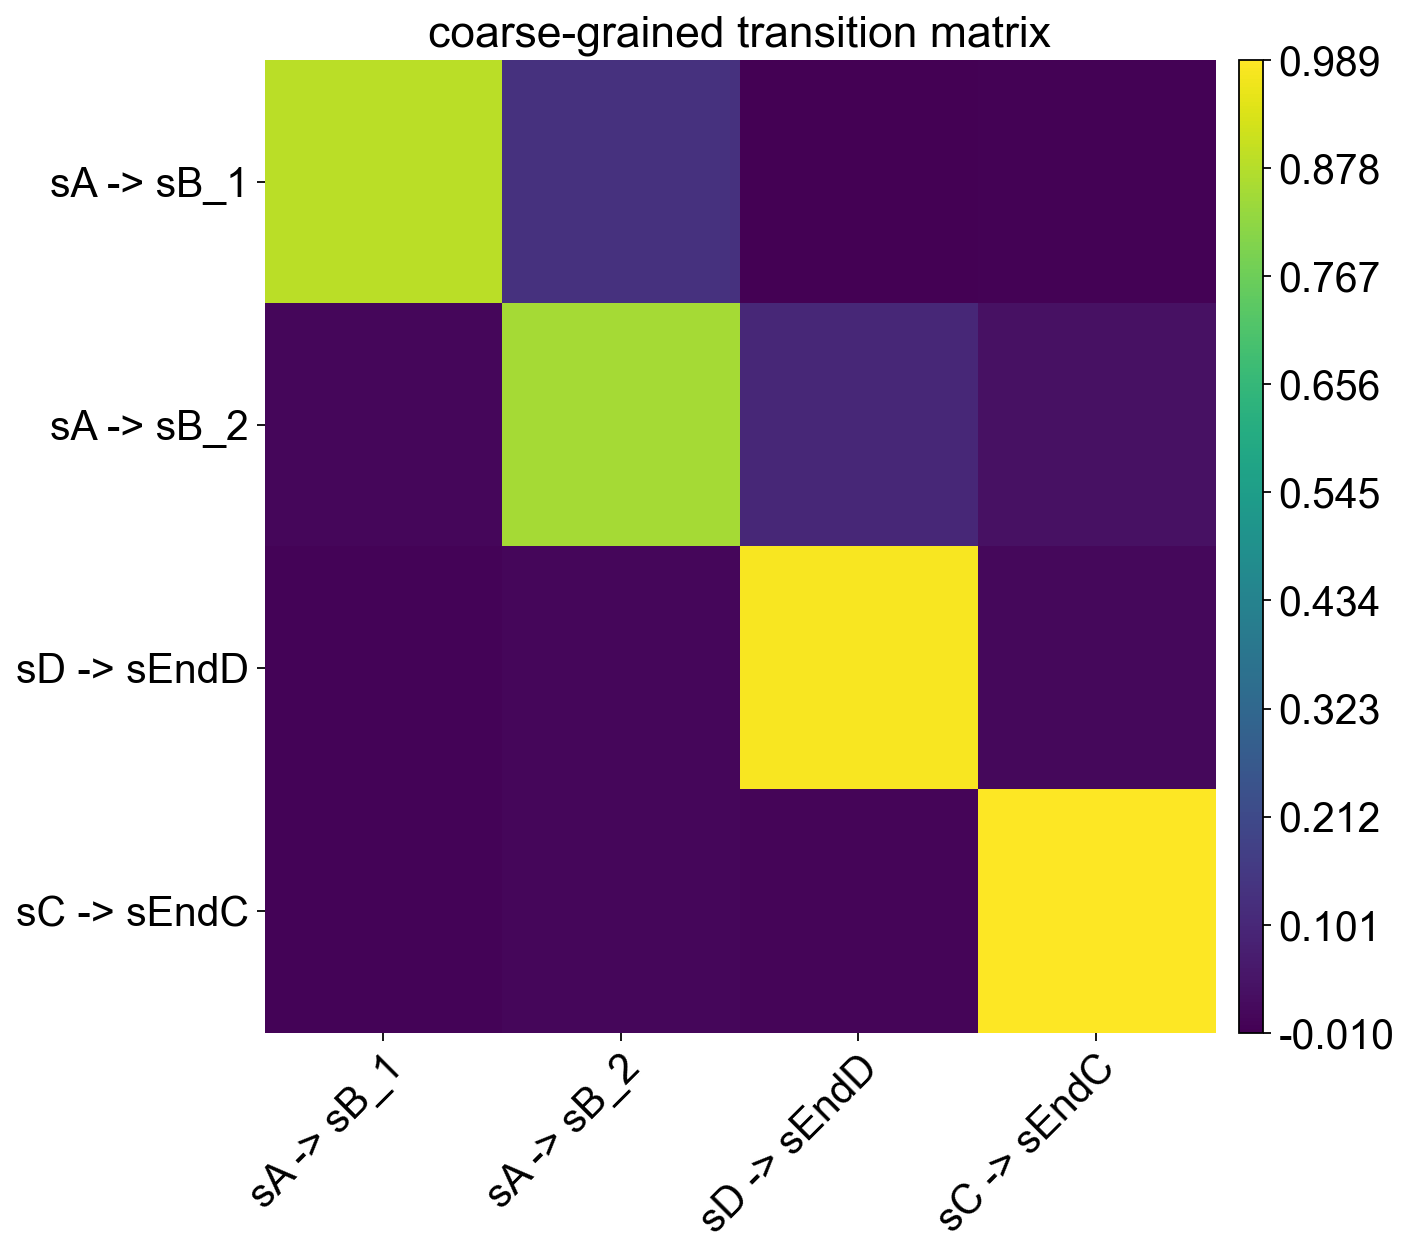

In [24]:
fig_kwargs = {'text_kwargs': {'fontsize': 40}, 'show_stationary_dist': False, 'annotate': False, 'cmap': 'viridis'}
if save_figure: fig_kwargs['save'] = "transition_matrix_coarse.pdf"
g_fwd.plot_coarse_T(**fig_kwargs)

## Identify initial and terminal states

Automatically determine initial and terminal states here.

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Adding `adata.obs['initial_states']`
       `adata.obs['initial_states_colors']`



/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


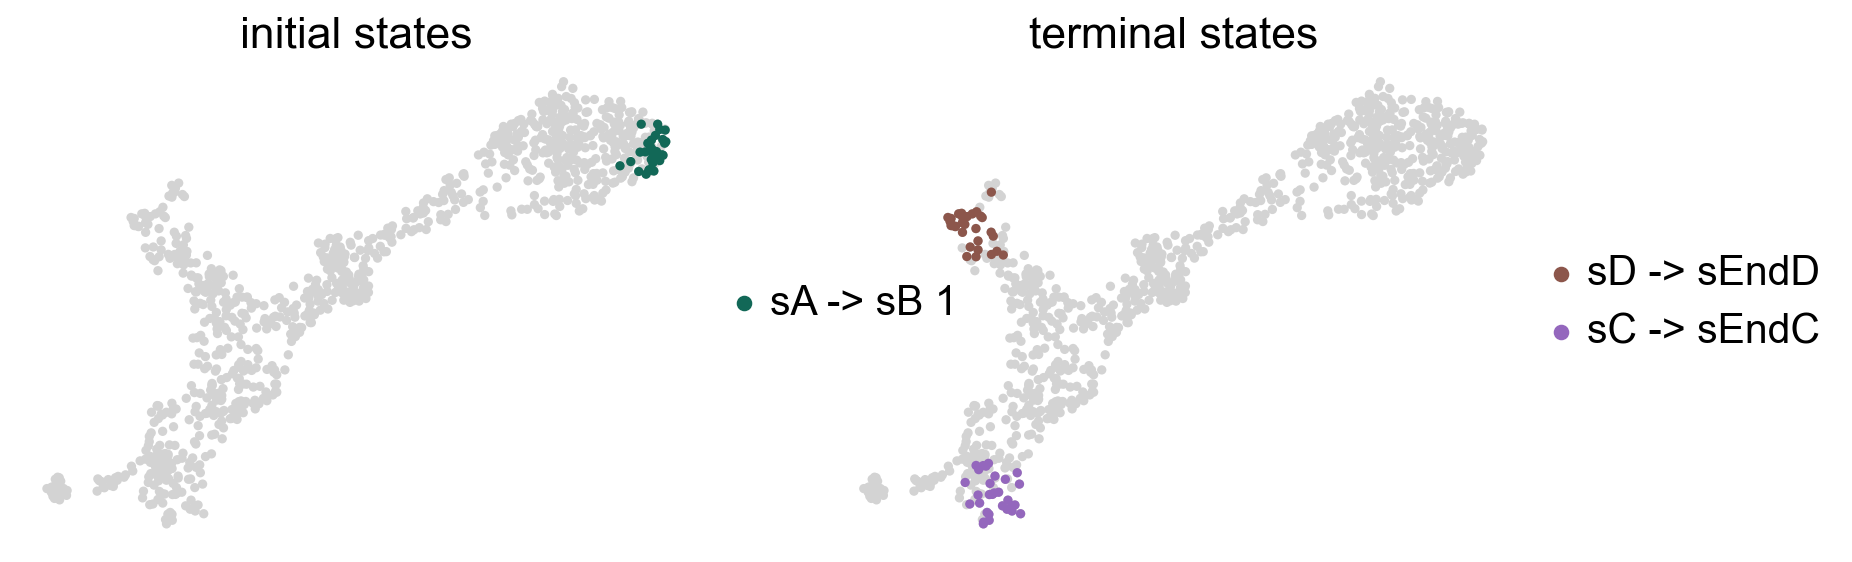

In [25]:
g_fwd.compute_terminal_states()
g_fwd._compute_initial_states()

# plot using scvelo
scv.pl.scatter(adata, c=['initial_states', 'terminal_states'], legend_loc='right')

## Plot the transition matrix

In [26]:
# get the transition matrix
T = adata.obsp['T_fwd'].A

# sort the cells by macrostate membership
meta_states_probs = g_fwd.macrostates_memberships
cell_assignment = meta_states_probs.argmax(1).X.flatten()
p = np.argsort(cell_assignment)
print(meta_states_probs.names)

['sA -> sB_1' 'sA -> sB_2' 'sD -> sEndD' 'sC -> sEndC']


Look at the distribution of non-zero values

<AxesSubplot:ylabel='Density'>

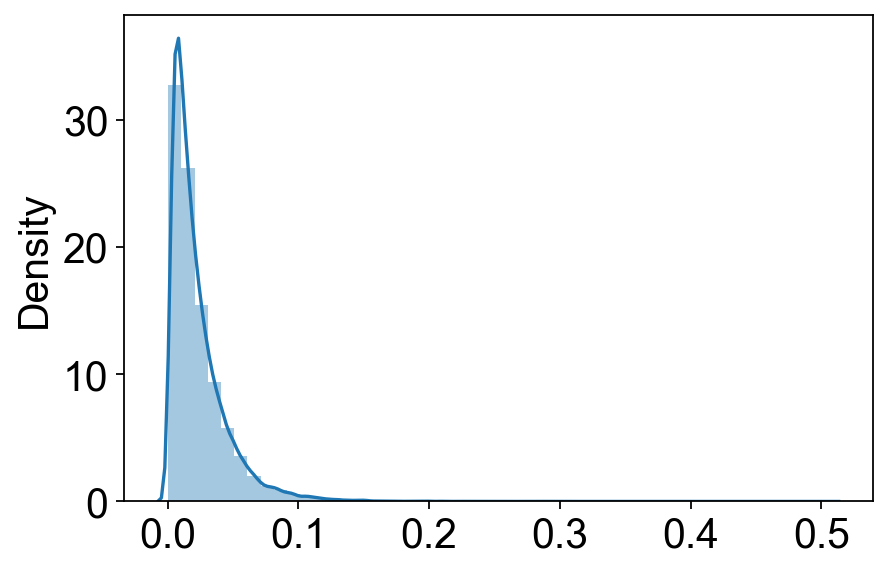

In [27]:
sns.distplot(T[T>0])

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


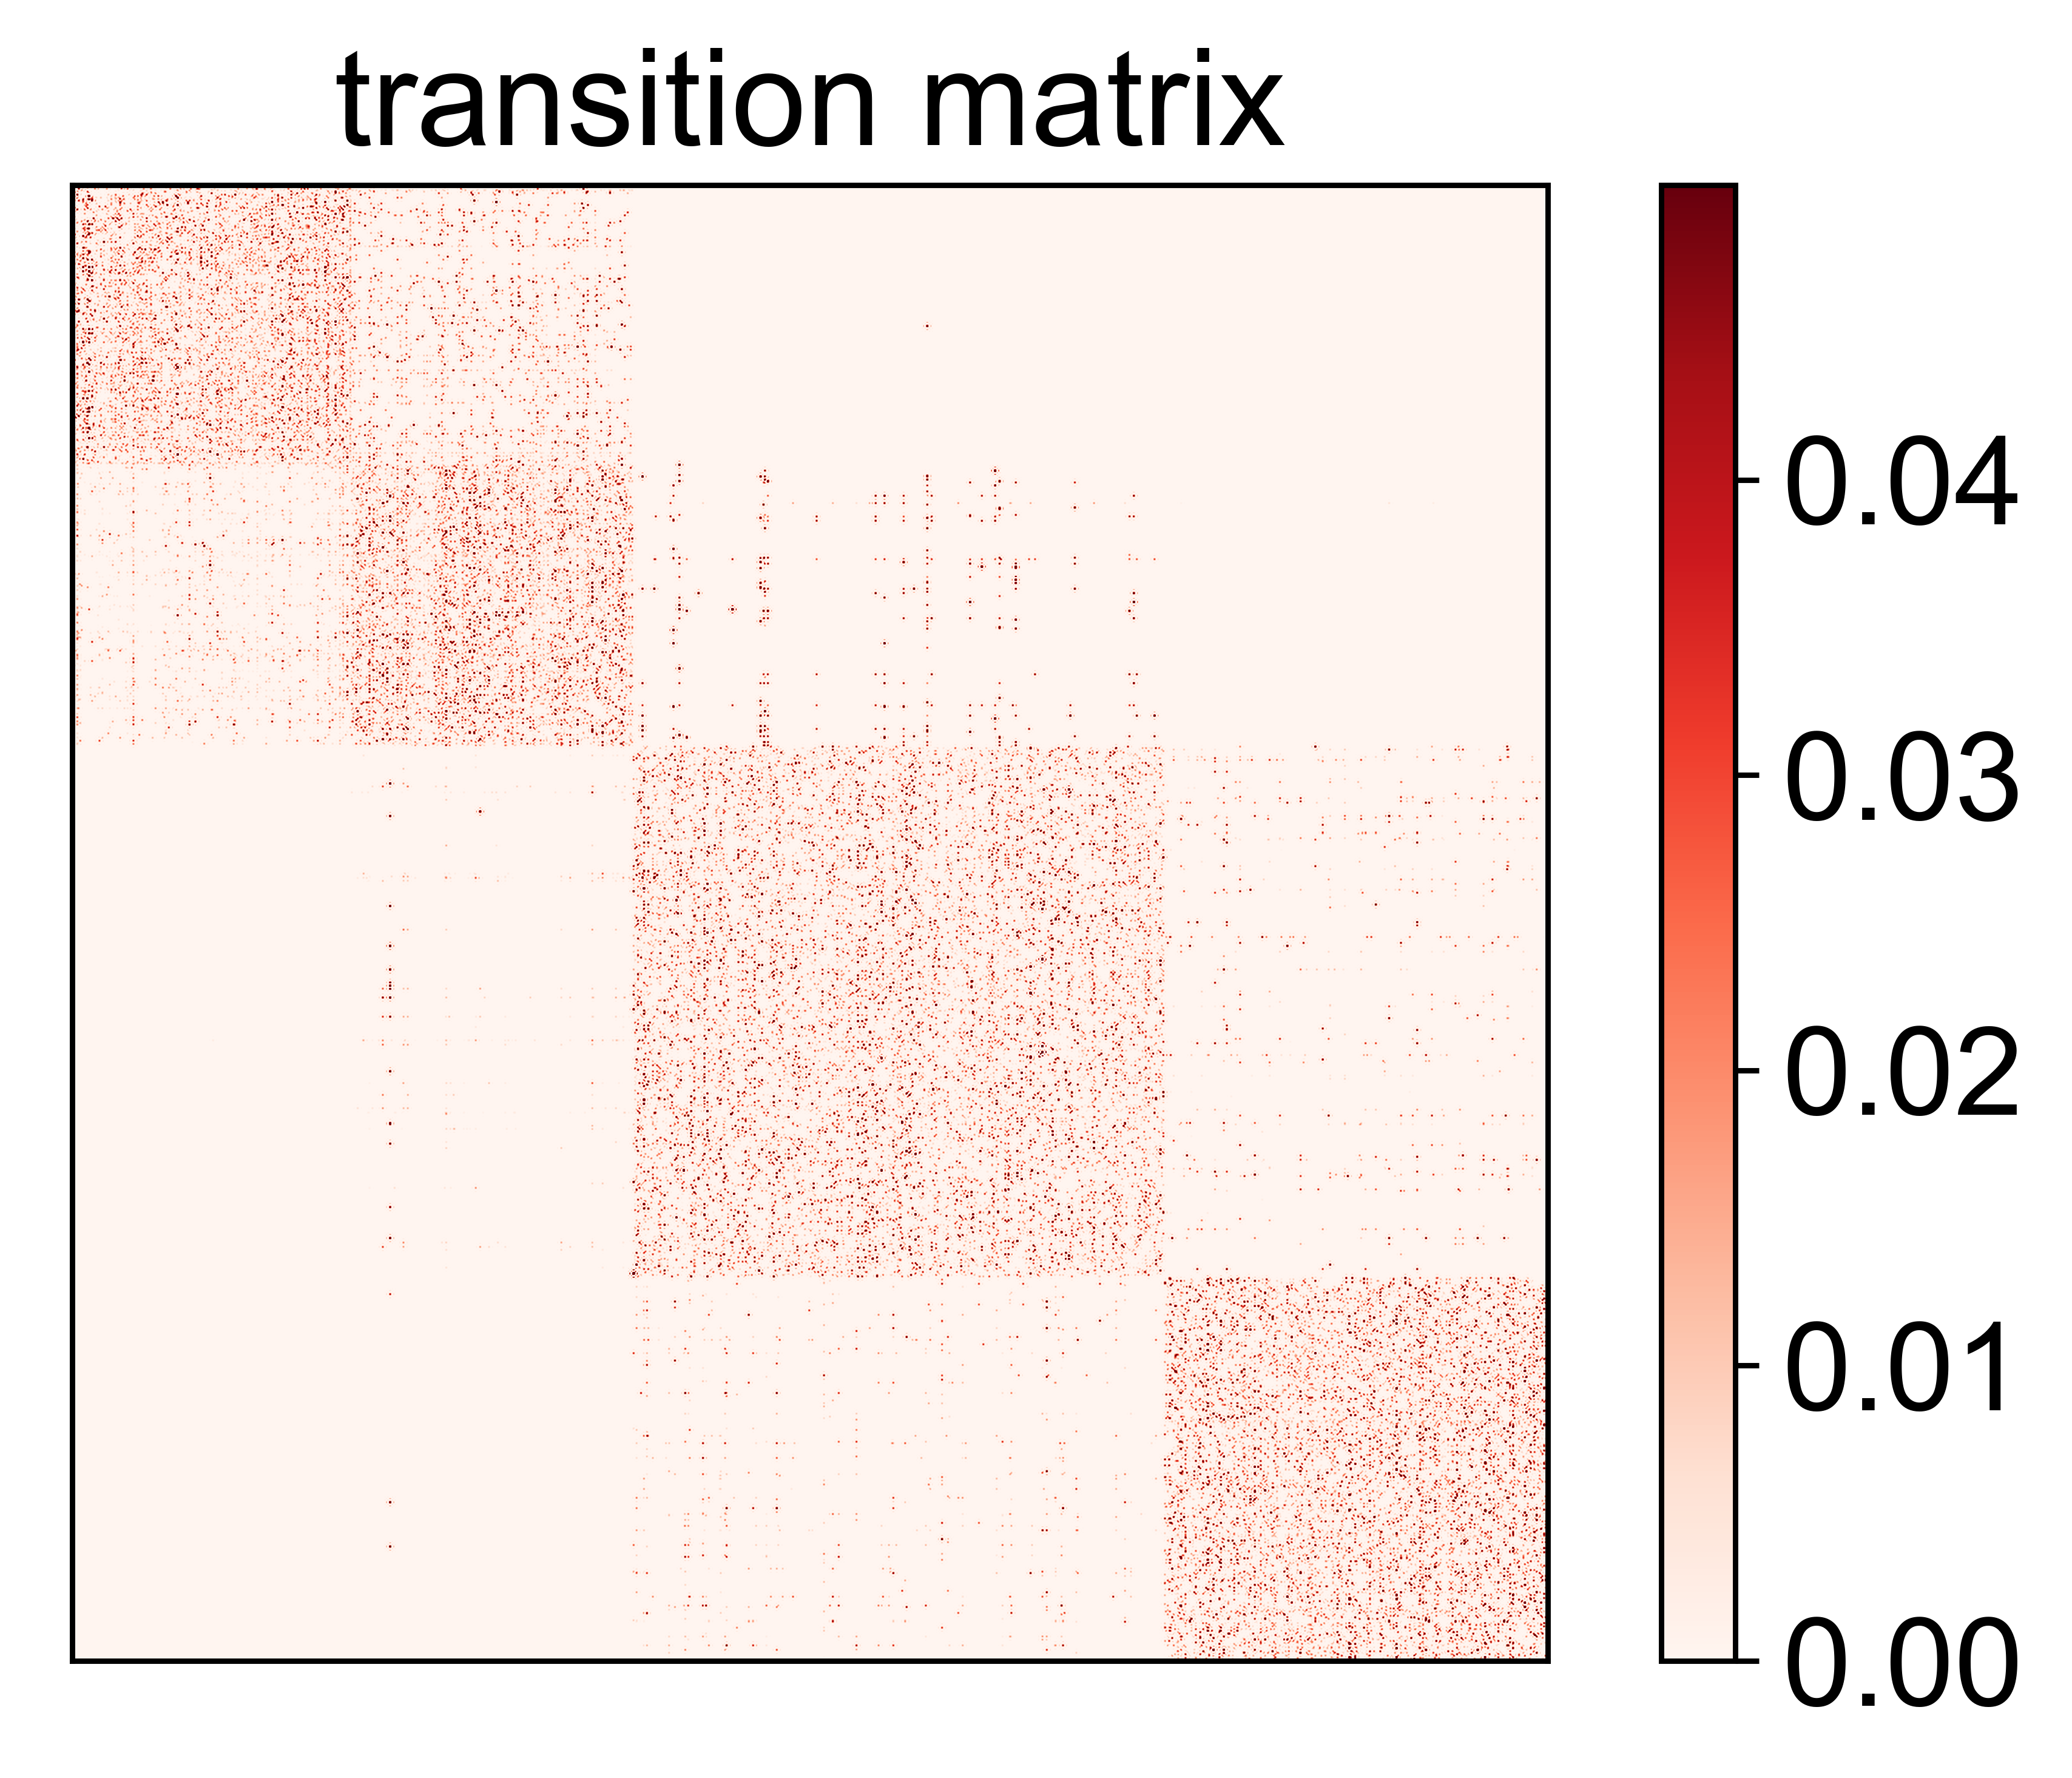

In [28]:
vmax = np.quantile(T[T>0], 0.90)

fig = plt.figure(None, dpi=400)
ax = fig.add_subplot(111)

cax = ax.imshow(T[p ,:][:, p], vmin=0, vmax=vmax, cmap='Reds', interpolation='sinc', filterrad=4.0)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('transition matrix')

plt.colorbar(mappable=cax)
plt.savefig(FIG_DIR / "transition_matrix.pdf", bbox_inches='tight')
plt.show()

## Compute absorption probabilities

Computing absorption probabilities


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/2 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)
saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/fig_1_concept/fate_map.pdf


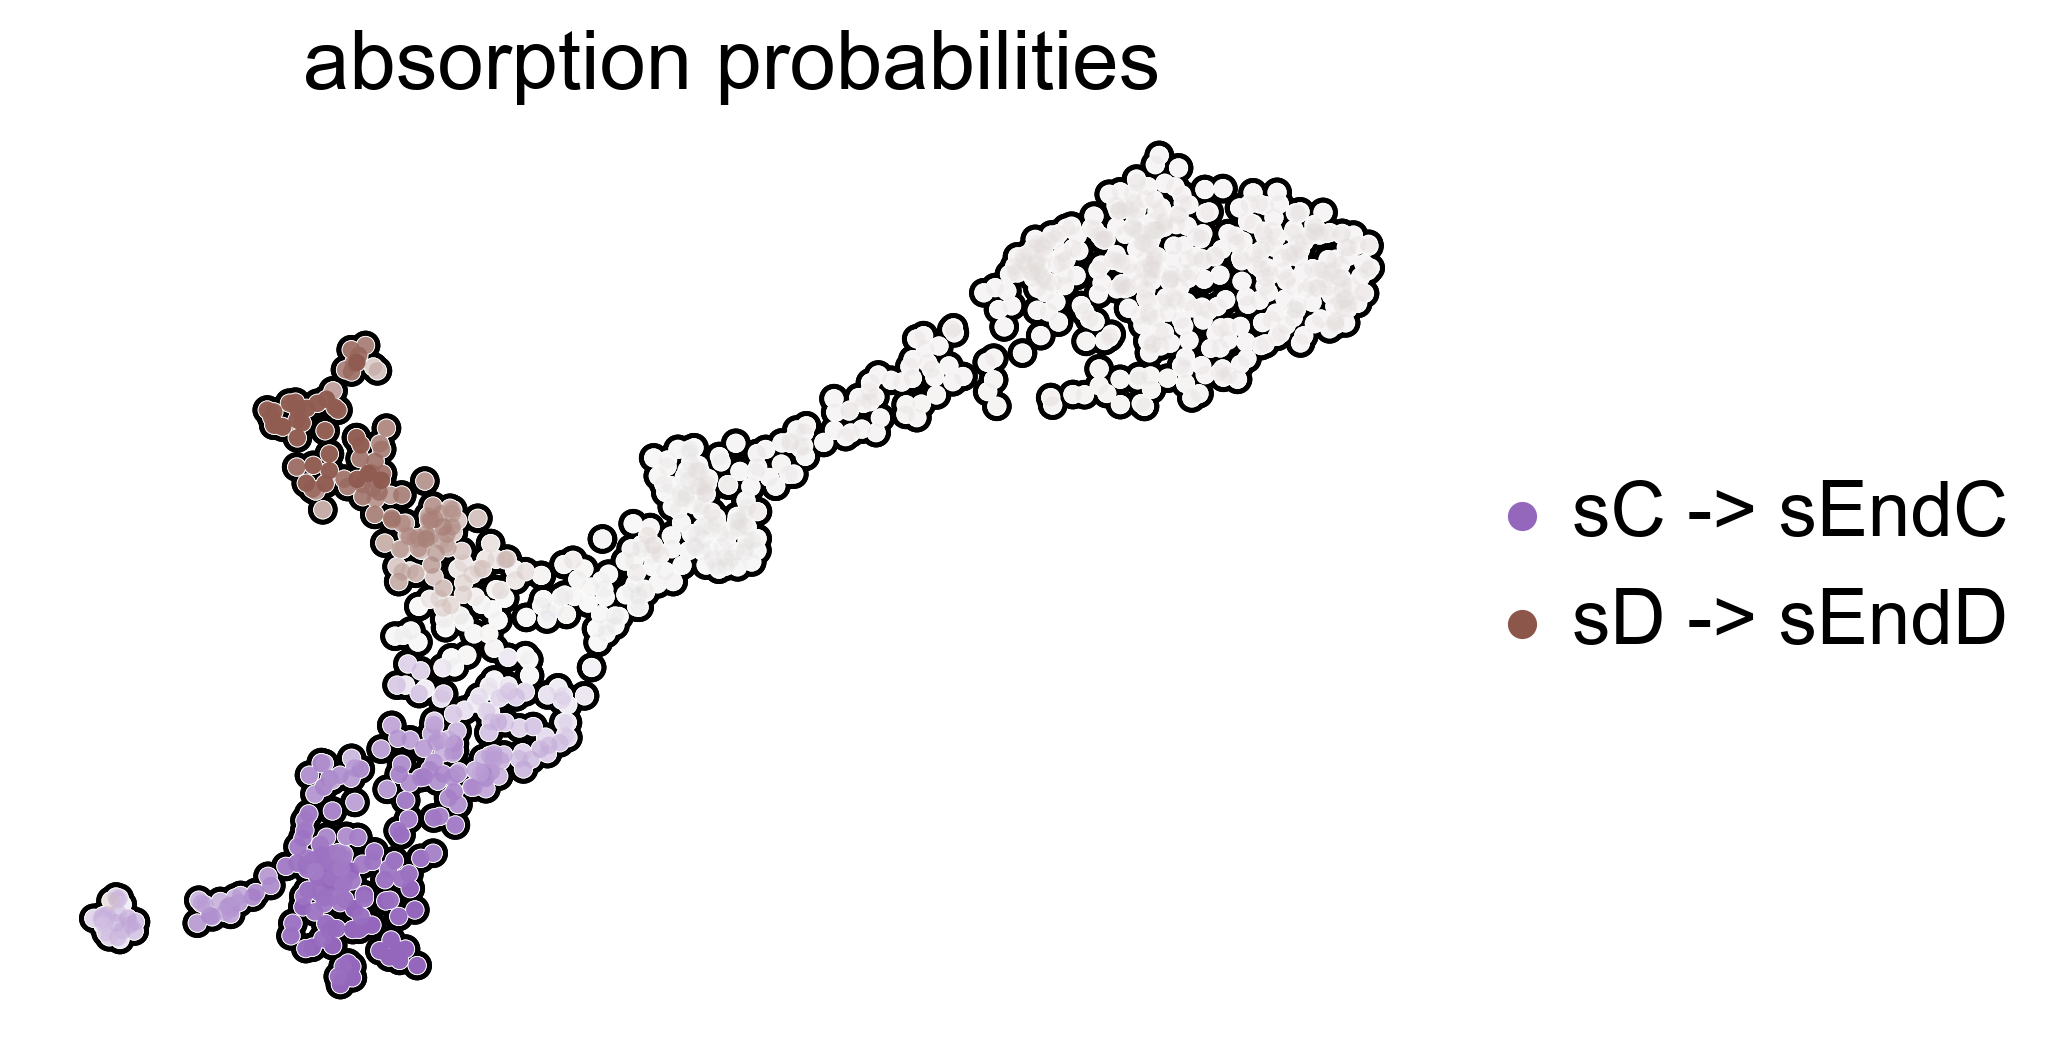

In [29]:
g_fwd.compute_absorption_probabilities(keys=['sD -> sEndD', 'sC -> sEndC'])

fig_kwargs = {'dpi': 150, 'add_outline': True, 'legend_loc': 'right'}
if save_figure: fig_kwargs['save'] = "fate_map.pdf"
g_fwd.plot_absorption_probabilities(**fig_kwargs)

## Visualise gene expression trends

Prepare for plotting by copying over the lineage probabilities to the raw object.  

In [30]:
adata_raw.obsm['to_terminal_states'] = adata.obsm['to_terminal_states'].copy()
adata_raw.uns['terminal_states_colors'] = adata.uns['terminal_states_colors'].copy()

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Select some lineage-dependent genes for plotting

saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/fig_1_concept/gene_expression_embedding.pdf


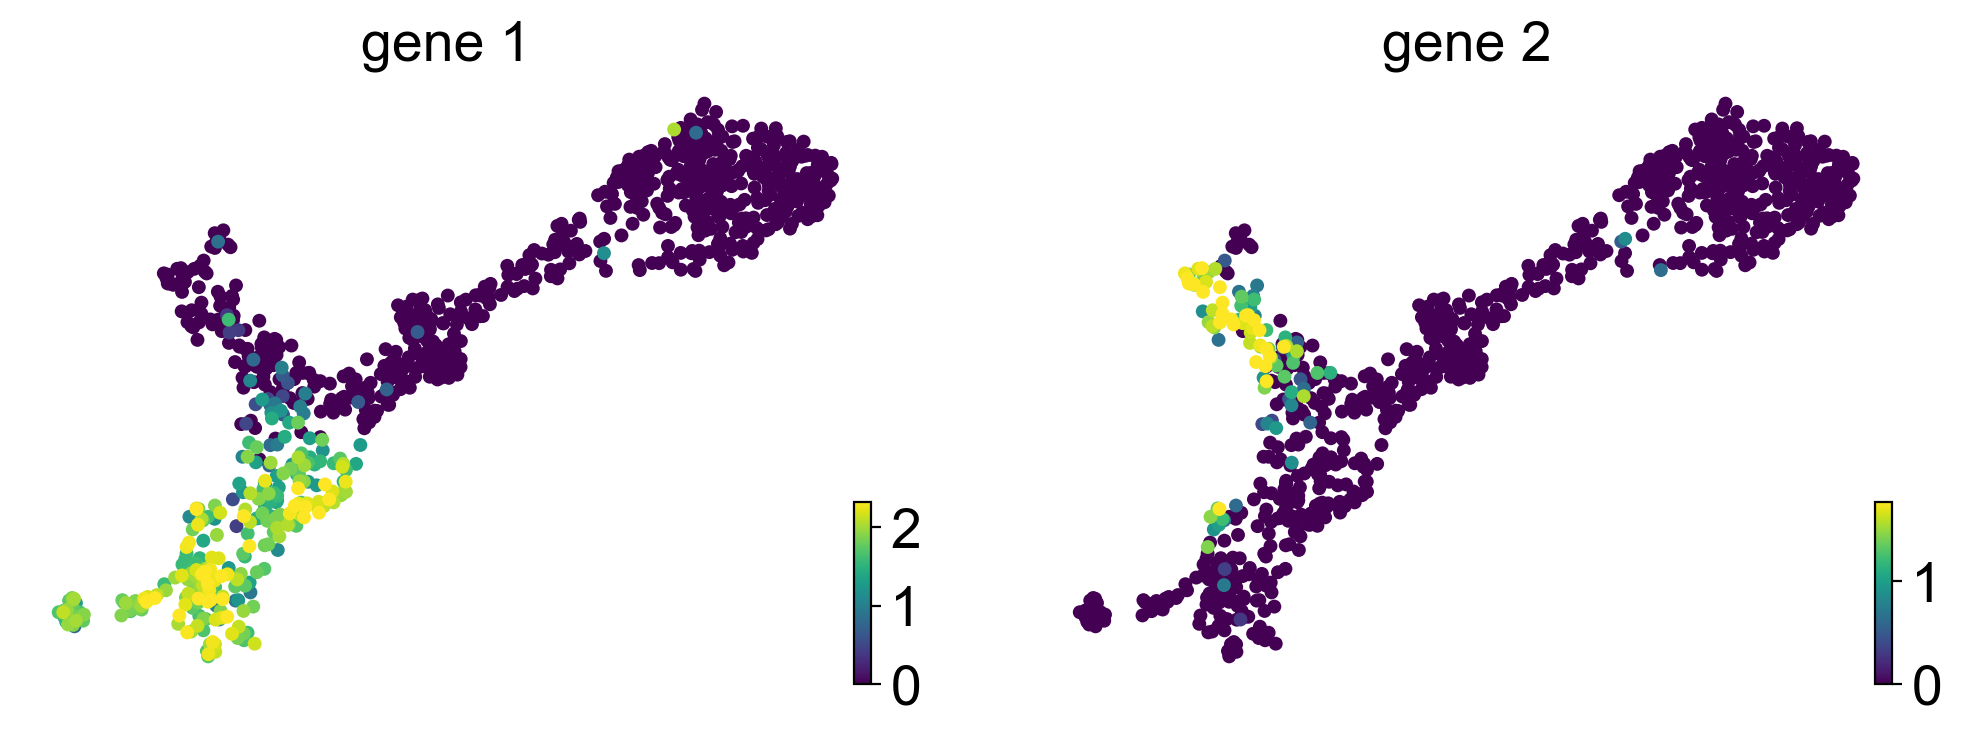

In [31]:
fig_kwargs = {'color': ['114','72'], 
              'perc': [0, 98], 
              'dpi': 100, 
              'title': ['gene 1', 'gene 2'], 
              'color_map': 'viridis', 
              'size': 100}
if save_figure: fig_kwargs['save'] = "gene_expression_embedding.pdf"
scv.pl.scatter(adata, **fig_kwargs)

Computing trends using `1` core(s)


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/2 [00:00<?, ?gene/s]

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

    Finish (0:00:00)
Plotting trends


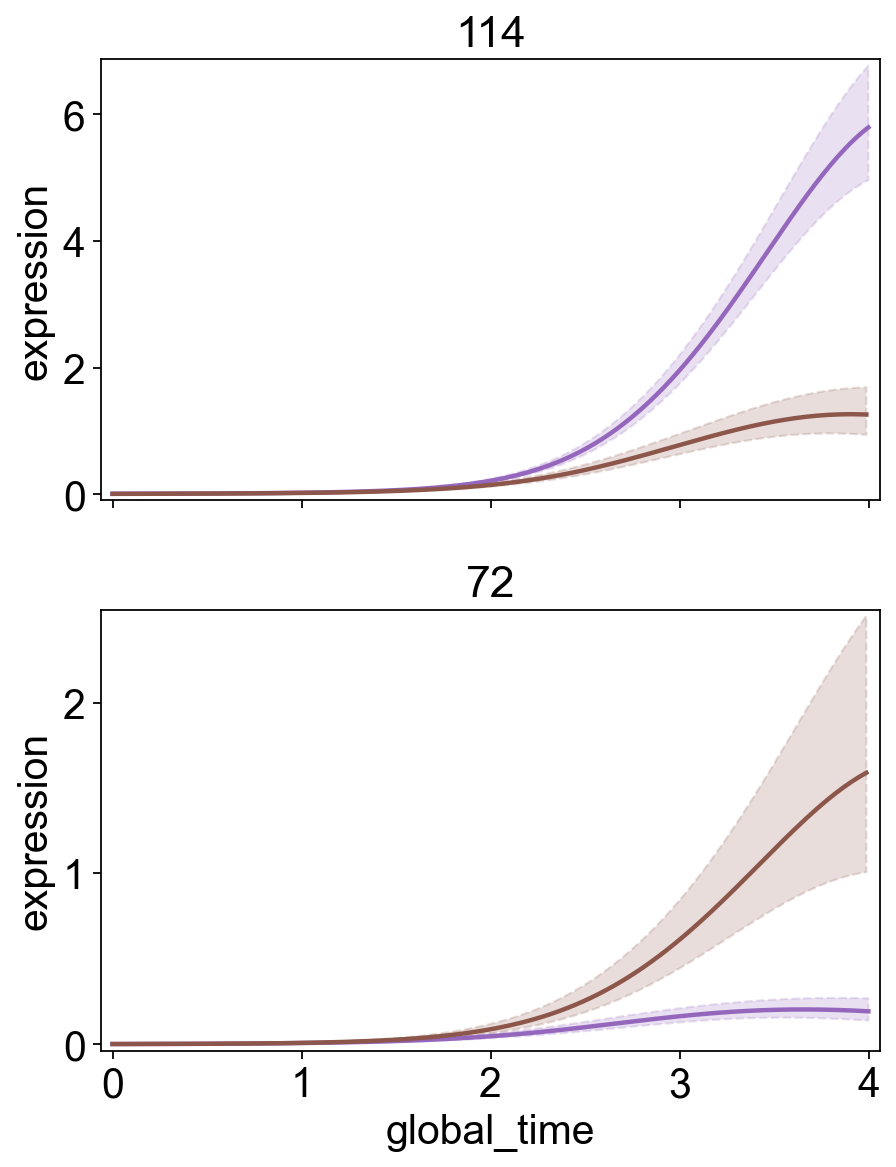

In [32]:
fig_kwargs = {'data_key': 'Ms', 
              'genes': ['114', '72'], 
              'ncols': 1, 
              'legend_loc': None, 
              'time_key': 'global_time', 
              'same_plot': True, 
              'hide_cells': True}
if save_figure: fig_kwargs['save'] = "gene_expression_time.pdf"

model = cr.ul.models.GAM(adata_raw, n_knots=6, spline_kwargs={'lam': 5})
cr.pl.gene_trends(adata_raw, model=model, **fig_kwargs)

## Show heatmap of potential lineage drivers

Find some genes which correlate well with fate probs

In [33]:
g_fwd.compute_lineage_drivers(use_raw=True)

Adding `adata.raw.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


sC -> sEndC_corr  sC -> sEndC_pval  sC -> sEndC_qval  sC -> sEndC_ci_low  \
114          0.836946      0.000000e+00      0.000000e+00            0.817362   
36           0.805681     2.493756e-271     3.054851e-269            0.782786   
26           0.803828     8.522074e-269     6.959694e-267            0.780741   
147          0.796126     1.310556e-258     8.027153e-257            0.772246   
119          0.792078     1.810641e-253     8.872142e-252            0.767786   
..                ...               ...               ...                 ...   
124         -0.496772      2.276612e-66      1.859233e-65           -0.542072   
121         -0.539751      4.906057e-81      4.623015e-80           -0.582261   
113         -0.555381      5.375464e-87      5.487453e-86           -0.596825   
123         -0.556579      1.813070e-87      1.931314e-86           -0.597941   
112         -0.606889     1.823287e-109     2.127169e-108           -0.644629   

     sC -> sEndC_ci_high  sD -> sEndD_corr  sD -> sEndD_pval  \
114             0.854598         -0.836946      0.000000e+00   
36              0.826398         -0.805681     2.492603e-271   
26              0.824724         -0.803828     8.520538e-269   
147             0.817759         -0.796126     1.310119e-258   
119             0.814096         -0.792078     1.809440e-253   
..                   ...               ...               ...   
124            -0.448594          0.496772      2.277739e-66   
121            -0.494297          0.539750      4.907492e-81   
113            -0.510981          0.555380      5.377955e-87   
123            -0.512261          0.556579      1.812863e-87   
112            -0.566198          0.606888     1.825320e-109   

     sD -> sEndD_qval  sD -> sEndD_ci_low  sD -> sEndD_ci_high  
114      0.000000e+00           -0.854599            -0.817362  
36      3.053439e-269           -0.826399            -0.782786  
26      6.958440e-267           -0.824724            -0.780741  
147     8.024480e-257           -0.817759            -0.772246  
119     8.866254e-252           -0.814096            -0.767786  
..                ...                 ...                  ...  
124      1.860154e-65            0.448594             0.542071  
121      4.624367e-80            0.494297             0.582260  
113      5.489996e-86            0.510980             0.596825  
123      1.931093e-86            0.512261             0.597941  
112     2.129540e-108            0.566197             0.644629  

[245 rows x 10 columns]

Select a lineage and compute the heatmap

In [34]:
adata.raw.varm['terminal_lineage_drivers']

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


sC -> sEndC_corr  sC -> sEndC_pval  sC -> sEndC_qval  sC -> sEndC_ci_low  \
0           -0.067595          0.032550          0.052123           -0.129047   
1           -0.014246          0.652826          0.723721           -0.076171   
2           -0.009620          0.761316          0.824932           -0.071570   
3           -0.006520          0.836877          0.885856           -0.068486   
4           -0.014801          0.640223          0.716232           -0.076724   
..                ...               ...               ...                 ...   
245         -0.061272          0.052734          0.081893           -0.122798   
246         -0.012067          0.703186          0.772558           -0.074004   
247          0.034907          0.270179          0.353978           -0.027145   
248          0.006404          0.839748          0.885856           -0.055611   
249         -0.084556          0.007444          0.013411           -0.145785   

     sC -> sEndC_ci_high  sD -> sEndD_corr  sD -> sEndD_pval  \
0              -0.005625          0.067594          0.032554   
1               0.047790          0.014245          0.652839   
2               0.052405          0.009619          0.761343   
3               0.055495          0.006520          0.836890   
4               0.047235          0.014801          0.640231   
..                   ...               ...               ...   
245             0.000724          0.061271          0.052735   
246             0.049964          0.012066          0.703187   
247             0.096691         -0.034907          0.270178   
248             0.068370         -0.006404          0.839747   
249            -0.022682          0.084556          0.007445   

     sD -> sEndD_qval  sD -> sEndD_ci_low  sD -> sEndD_ci_high  
0            0.052128            0.005624             0.129046  
1            0.723736           -0.047790             0.076171  
2            0.824935           -0.052406             0.071569  
3            0.885883           -0.055496             0.068485  
4            0.716240           -0.047236             0.076724  
..                ...                 ...                  ...  
245          0.081894           -0.000725             0.122798  
246          0.772560           -0.049964             0.074004  
247          0.353977           -0.096691             0.027145  
248          0.885883           -0.068370             0.055611  
249          0.013411            0.022682             0.145785  

[245 rows x 10 columns]

In [35]:
lin = 'sD -> sEndD'
corr = adata.raw.varm['terminal_lineage_drivers'].sort_values(by=f"{lin}_corr", ascending=False)

corr = corr.head(50)
print(f"Selected {len(corr)} genes.")

Selected 50 genes.


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Computing trends using `1` core(s)


  0%|          | 0/50 [00:00<?, ?gene/s]

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

did not converge


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

    Finish (0:00:03)


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

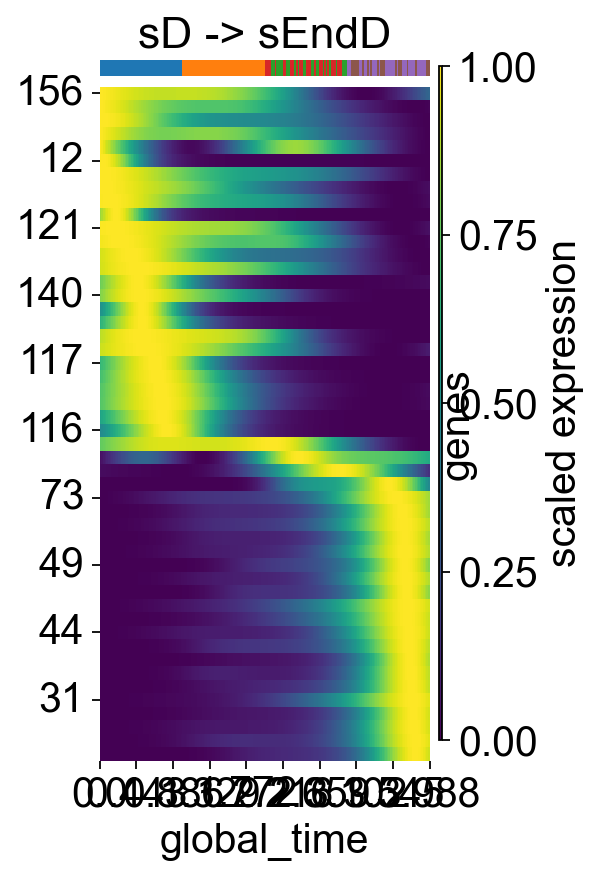

In [36]:
fig_kwargs = {'genes': corr.index, 
              'lineages':[lin], 
              'cluster_key': 'lineage', 
              'time_key': 'global_time', 
              'data_key': 'Ms', 
              'show_absorption_probabilities': False, 
              'figsize': (4, 6), 
              'show_all_genes': False, 
              'weight_threshold': (0.05, 0.05)}
if save_figure: fig_kwargs['save'] = 'heatmap.pdf'

model = cr.ul.models.GAM(adata_raw, n_knots=10)
cr.pl.heatmap(adata_raw, model, **fig_kwargs) 

Look at early, intermediate and late genes:

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/fig_1_concept/early_late_genes.pdf


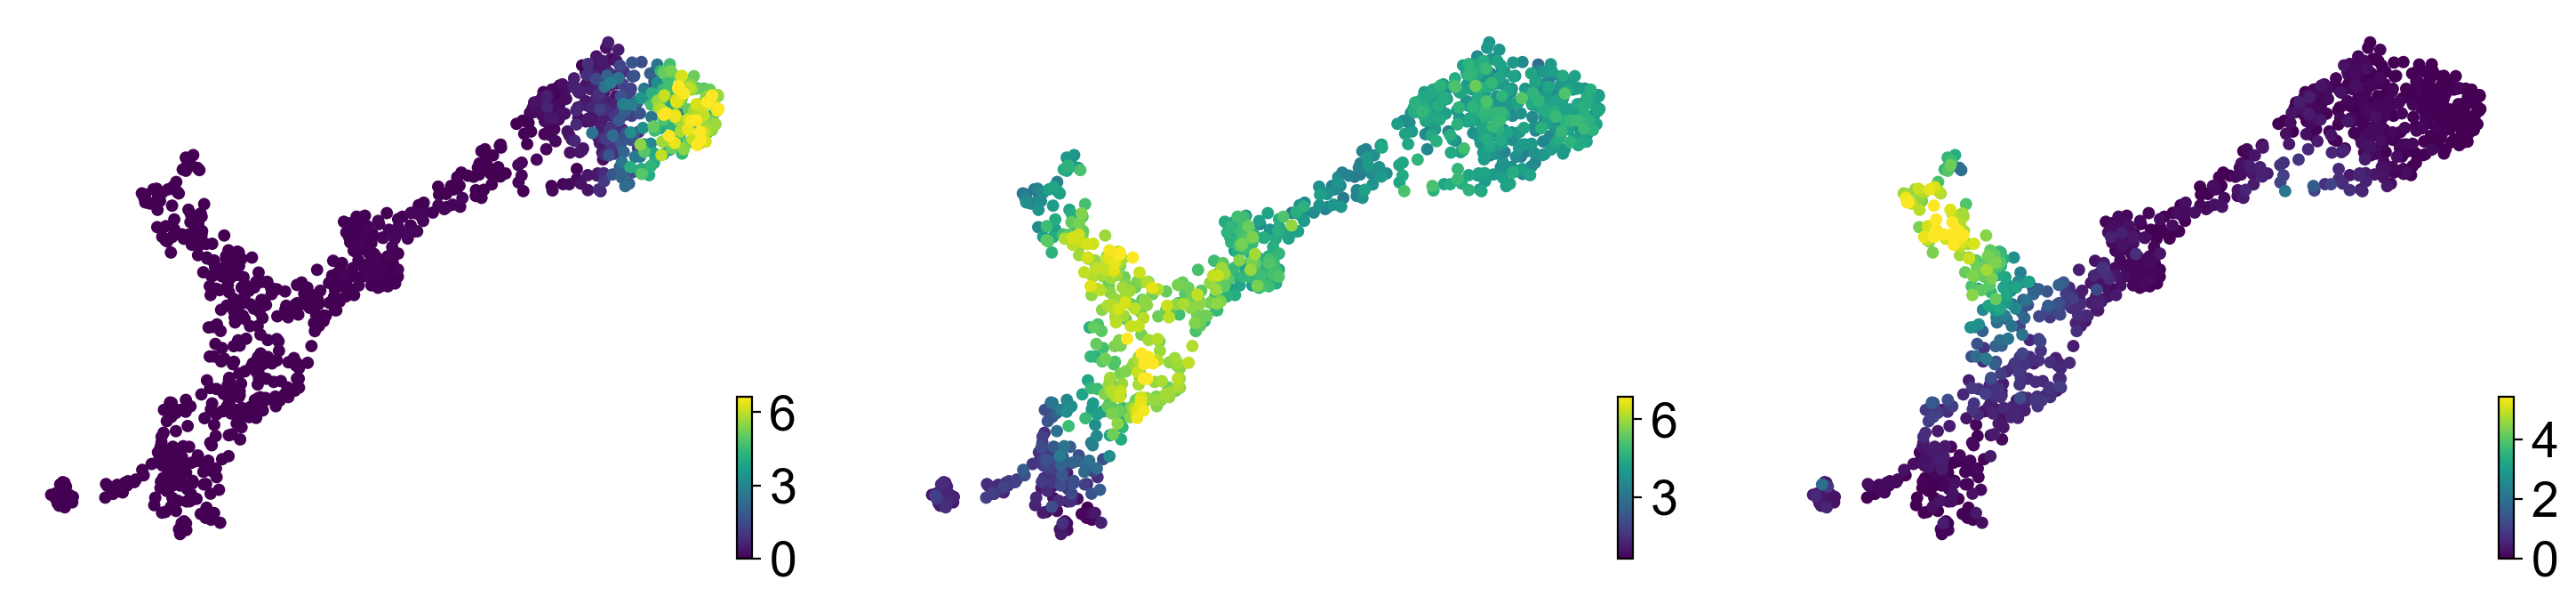

In [37]:
fig_kwargs = {'color': ['11', '54',  '43'], 
              'legend_loc': 'on data', 
              'layer': 'Ms', 
              'perc': [0, 99], 
              'color_map': 'viridis', 
              'title': '', 
              'dpi': 100, 
              'size': 100}
if save_figure: fig_kwargs['save'] = 'early_late_genes.pdf'

scv.pl.scatter(adata_raw, **fig_kwargs)